In [1]:
import torch
import util
import custum_dataset
from torch.utils.data import DataLoader
from model import Model
import torch.optim.lr_scheduler as lr_scheduler


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
path = f'C:/Users/yy/Desktop/dl_project/data/data.txt'  
split = 0.8
data_train,stoi,itos = util.load_data_with_split(path,split,type='train')
data_test,_,_ = util.load_data_with_split(path,split,type='test')

c = util.config()


dataset_train = custum_dataset.CustomDataset(c.sequence_l,device,stoi,itos,data_train,repeat = False)
data_loader_train = DataLoader(dataset_train, c.batch_size, shuffle=True)

dataset_test = custum_dataset.CustomDataset(c.sequence_l,device,stoi,itos,data_test,repeat = False)
data_loader_test = DataLoader(dataset_test, c.batch_size, shuffle=True)

model = Model(stoi=dataset_train.stoi)
m = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=c.learning_rate)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer,mode='min', factor=0.1, patience=5)



# Training loop
lr decay: https://pytorch.org/docs/stable/optim.html

In [3]:
train_loss = []
test_loss = []
perplexity_train = []
perplexity_test = []

for epoch in range(100):
    print("epoch: ", epoch)
    model.train()
    inputs, targets = next(iter(data_loader_train))
    _,loss = m(inputs,'train', targets)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

        
    model.eval()
    inputs_t, targets_t = next(iter(data_loader_test))

    with torch.inference_mode():
        _,loss_t = m(inputs_t,'train', targets_t)
    scheduler.step(loss_t)

    print(loss)
    print(loss_t)

    train_loss.append(loss.cpu().detach().numpy())
    test_loss.append(loss_t.cpu().detach().numpy())
    perplexity_train.append(torch.exp(loss).cpu().detach().numpy())
    perplexity_test.append(torch.exp(loss_t).cpu().detach().numpy())



epoch:  0
tensor(4.3855, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(6.2467, device='cuda:0')
epoch:  1
tensor(6.0536, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(4.6161, device='cuda:0')
epoch:  2
tensor(4.5183, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(4.5196, device='cuda:0')
epoch:  3
tensor(4.4551, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(4.2829, device='cuda:0')
epoch:  4
tensor(4.2784, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(4.0810, device='cuda:0')
epoch:  5
tensor(4.0863, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.8917, device='cuda:0')
epoch:  6
tensor(3.8892, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.6655, device='cuda:0')
epoch:  7
tensor(3.6906, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.4900, device='cuda:0')
epoch:  8
tensor(3.5189, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.3681, device='cuda:0')
epoch:  9
tensor(3.3509, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.332

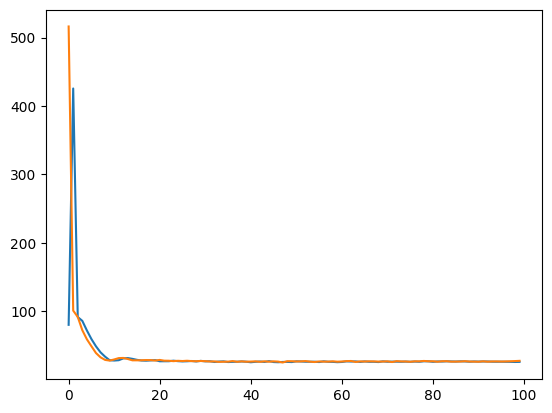

In [4]:
import matplotlib.pyplot as plt
import numpy as np
epoch_list = np.arange(0,len(train_loss))
plt.plot(epoch_list,perplexity_train)
plt.plot(epoch_list,perplexity_test)

array(3.2415125, dtype=float32)

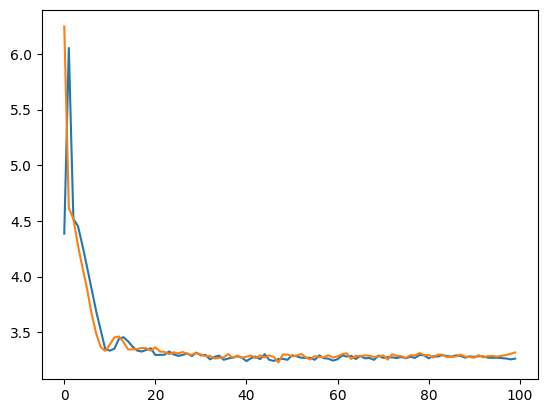

In [5]:
epoch_list = np.arange(0,len(train_loss))
plt.plot(epoch_list,train_loss)
plt.plot(epoch_list,test_loss)
min(train_loss)


# save model

In [6]:
# save model
from pathlib import Path

# 1. Create models directory 
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path 
MODEL_NAME = "100_step_decay_with_init_1.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict 
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=m.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH) 

Saving model to: models\100_step_decay_with_init_1.pth


In [7]:
MODEL_SAVE_PATH

WindowsPath('models/100_step_decay_with_init_1.pth')

# generation:

In [14]:
seed = " "


input_idx = util.encode(seed,stoi)

input_idx = torch.tensor(input_idx,dtype=torch.long)
input_idx = torch.unsqueeze(input_idx, 0).to(device)


In [23]:
m.eval()
with torch.no_grad():
    out = m.generate(5,input_idx,'hi')
    print(util.decode(out,itos))

TypeError: unhashable type: 'list'

In [13]:
m.eval()
with torch.no_grad():
    out = m.generate(100,input_idx,'high_prob')
    print(util.decode(out,itos))


RuntimeError: Tensors must have same number of dimensions: got 2 and 1

# load model

In [4]:
m.load_state_dict(torch.load('models/100_step_decay_with_init_1.pth'))

seed = "O god! O god! "


input_idx = util.encode(seed,stoi)

input_idx = torch.tensor(input_idx,dtype=torch.long)
input_idx = torch.unsqueeze(input_idx, 0).to(device)


m.eval()
with torch.no_grad():
    out = m.generate(100,input_idx,'hi')
    print(util.decode(out,itos))




O god! O god! ahthsenontidC BtaIedlti Tn C
tef 
  nl uese 
bko ad w',wasst ts s ESmiebss, ft T Ro b,Y mnctH

  ohe


In [7]:
m.eval()
with torch.no_grad():
    out = m.generate(100,input_idx,'high_prob')
    print(util.decode(out,itos))